<a href="https://colab.research.google.com/github/chuang-ma-ku/optimal-classifier/blob/main/SEL_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-43-bc8252839ad5>:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


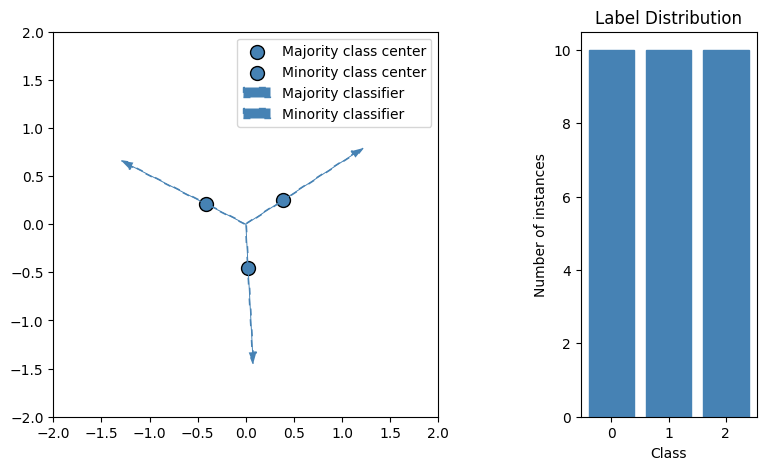

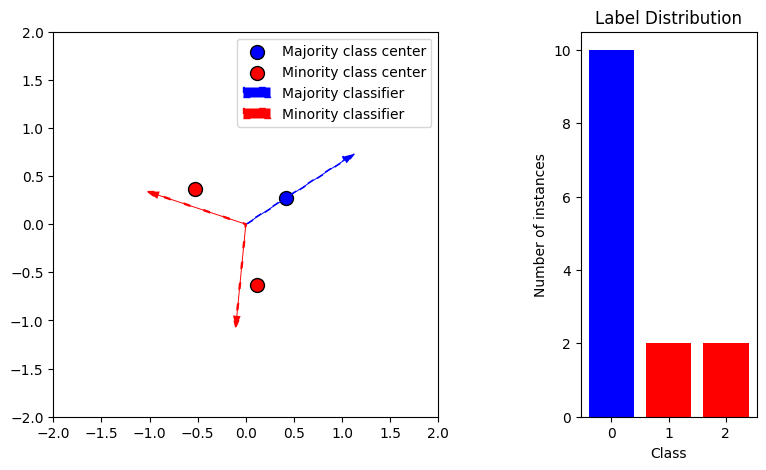

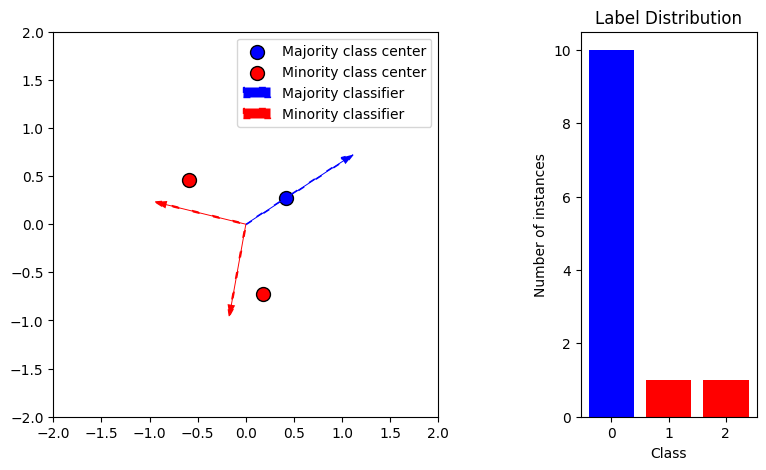

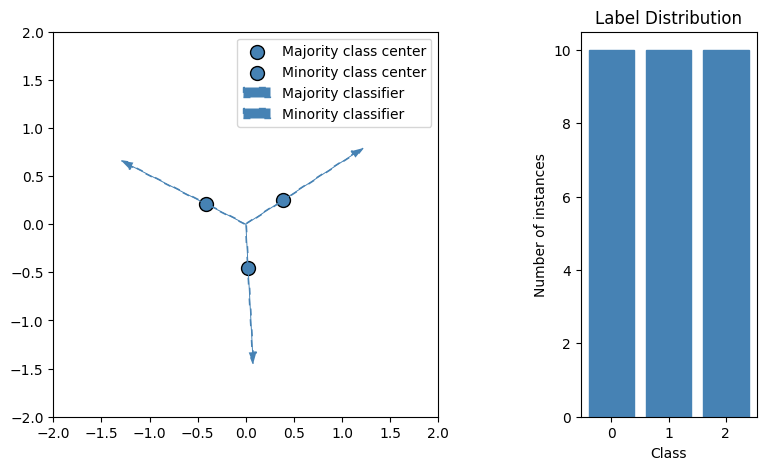

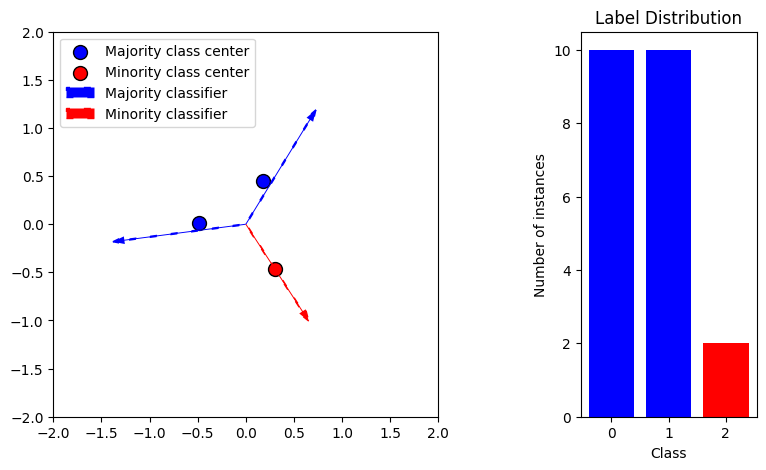

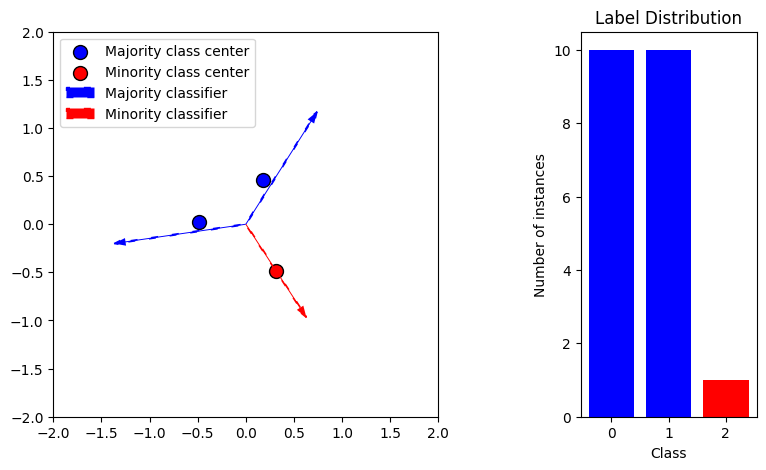

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from numpy.linalg import svd

# 生成随机正交矩阵P，只生成一次，并在每次生成W和H时使用。
P = None

def generate_SEL_matrix(k, n, rho, R):
    y = []
    for c in range(k):
        if c < rho * k:
            count = n  # 多数类
        else:
            count = int(n / R)  # 少数类
        y.extend([c] * count)
    y = np.array(y)
    Z_hat = -1 / k * np.ones((k, len(y)))
    for i in range(len(y)):
        Z_hat[y[i], i] += 1
    return Z_hat

def compute_svd(Z_hat):
    U, S, Vt = svd(Z_hat.T, full_matrices=False)
    Lambda = np.diag(S)
    return U, Lambda, Vt.T

# def generate_random_orthogonal_matrix(feat_in, num_classes):
#     a = np.random.random(size=(feat_in, num_classes))
#     P, _ = np.linalg.qr(a)
#     assert np.allclose(P.T @ P, np.eye(num_classes), atol=1e-07)
#     return P

def generate_random_orthogonal_matrix(feat_in, num_classes):
    global P
    if P is None:
        a = np.random.random(size=(feat_in, num_classes))
        P, _ = np.linalg.qr(a)
        # 在NumPy中验证P的列是正交的（即P.T @ P 接近单位矩阵）
        assert np.allclose(P.T @ P, np.eye(num_classes), atol=1e-07), np.max(np.abs(P.T @ P - np.eye(num_classes)))
    return P

def compute_HW(U, Lambda, V, d, k):
    R = generate_random_orthogonal_matrix(d, k-1)
    Lambda_half = np.diag(np.sqrt(Lambda.diagonal()[:k-1]))
    W_hat = R @ Lambda_half @ V.T[:k-1,:]
    H_hat = R @ Lambda_half @ U.T[:k-1,:]
    return H_hat, W_hat

def compute_class_centers(H_hat, Z):
    d, _ = H_hat.shape
    k = Z.shape[0]
    mu_c = np.zeros((d, k))
    n_c = np.sum(Z > 0, axis=1)

    for c in range(k):
        class_indices = Z[c, :] > 0
        mu_c[:, c] = np.mean(H_hat[:, class_indices], axis=1)

    return mu_c

def visualize(k, n, d, rho, R):
    Z = generate_SEL_matrix(k, n, rho, R)
    U, Lambda, V = compute_svd(Z)
    H, W = compute_HW(U, Lambda, V, d, k)
    mu_c = compute_class_centers(H, Z)

    # 设定颜色
    if R == 1:
        majority_color = minority_color = 'steelblue'  # 如果R为1，则使用同一种颜色
    else:
        # majority_color = '#19CAAD'
        # minority_color = '#F4606C'
        majority_color = 'blue'
        minority_color = 'red'

    # 设置画布
    plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.2)  # wspace参数控制子图间的空间


    ax0 = plt.subplot(gs[0])
    # majority_color = 'blue'
    # minority_color = 'green'
    for i in range(k):
        color = majority_color if i < rho * k else minority_color
        # 使用球形标记特征中心，并用不同颜色表示多数类和少数类
        plt.scatter(mu_c[0, i], mu_c[1, i], s=100, c=color, marker='o', edgecolors='k')
        # 使用虚线箭头表示分类器W，并用不同颜色表示多数类和少数类
        plt.arrow(0, 0, W[0, i], W[1, i], linestyle=(0, (5, 10)), color=color, width=0.01, head_width=0.08, length_includes_head=True)

    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.gca().set_aspect('equal', adjustable='box')

    # 添加图例
    plt.scatter([], [], s=100, c=majority_color, marker='o', label='Majority class center', edgecolors='k')
    plt.scatter([], [], s=100, c=minority_color, marker='o', label='Minority class center', edgecolors='k')
    plt.arrow(0, 0, 0, 0, linestyle=(0, (5, 10)), color=majority_color, width=0.01, head_width=0.08, length_includes_head=True, label='Majority classifier')
    plt.arrow(0, 0, 0, 0, linestyle=(0, (5, 10)), color=minority_color, width=0.01, head_width=0.08, length_includes_head=True, label='Minority classifier')
    plt.legend()

    # 第二个图：数据标签分布
    ax1 = plt.subplot(gs[1])
    unique, counts = np.unique(Z.argmax(axis=0), return_counts=True)
    bars = ax1.bar(unique, counts, color=[majority_color if i < rho * k else minority_color for i in unique])
    if R == 1:
        for bar in bars:
            bar.set_color('steelblue')  # R为1时统一颜色
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of instances')
    ax1.set_title('Label Distribution')
    ax1.set_xticks(unique)

    plt.tight_layout()
    plt.show()

# 设置风格
#plt.style.use('seaborn-darkgrid')  # 选择一个风格，可根据需要更改
#plt.style.use('ggplot')
plt.style.use('default')

# 展示不同R值下的图像
rho_values = [0.3, 0.5]
R_values = [1,5,10]

for rho in rho_values:
    for R in R_values:
        visualize(k=3, n=10, d=2, rho=rho, R=R)